In [2]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 10.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 MB 49.0 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 4.6 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.4/807.4 kB 14.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 52.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [torchaudio]6 [torchaudio]]


Preparamos el entorno para comenzar el entrenamiento

In [3]:
import pickle, os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Config
NUM_ITEMS = 752
NUM_GROUPS = 8
CONTEXT_LEN = 20
BATCH_SIZE = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# cargar dataset procesado
with open("../data/processed/trajectories_train.pkl", "rb") as f:
    trajectories = pickle.load(f)

print("Trayectorias cargadas:", len(trajectories))
print("Ejemplo keys:", trajectories[0].keys())


Device: cpu
Trayectorias cargadas: 16000
Ejemplo keys: dict_keys(['items', 'ratings', 'returns_to_go', 'timesteps', 'user_group'])


Definimos la clase RecommendationDataset, que es la encargada de transformar las trayectorias completas de cada usuario en ejemplos individuales adecuados para entrenar el Decision Transformer.

El modelo no procesa secuencias completas de longitud variable (por ejemplo, 112 películas).
En su lugar, trabaja con ventanas de tamaño fijo, llamadas context length (en este caso, 20 pasos).
El objetivo del dataset es tomar cada trayectoria y generar estos fragmentos fijos que el modelo pueda usar.

In [4]:
class RecommendationDataset(Dataset):
    def __init__(self, trajectories, context_length=20):
        self.trajectories = trajectories
        self.context_length = context_length

    def __len__(self):
        return len(self.trajectories)

    def __getitem__(self, idx):
        traj = self.trajectories[idx]

        items = traj["items"]
        ratings = traj["ratings"]
        rtg = traj["returns_to_go"]
        timesteps = traj["timesteps"]
        group = traj["user_group"]

        # ventana fija
        seq_len = min(len(items), self.context_length)

        if len(items) > self.context_length:
            start = np.random.randint(0, len(items) - self.context_length + 1)
        else:
            start = 0

        end = start + seq_len

        states = items[start:end]
        actions = items[start:end]

        targets = np.empty(seq_len, dtype=np.int64)
        targets[:-1] = items[start+1:end]
        targets[-1] = -1  # padding para el último

        rtg_seq = rtg[start:end].reshape(-1, 1)
        time_seq = timesteps[start:end]

        return {
            "states": torch.tensor(states, dtype=torch.long),
            "actions": torch.tensor(actions, dtype=torch.long),
            "rtg": torch.tensor(rtg_seq, dtype=torch.float32),
            "timesteps": torch.tensor(time_seq, dtype=torch.long),
            "groups": torch.tensor(group, dtype=torch.long),
            "targets": torch.tensor(targets, dtype=torch.long)
        }

train_dataset = RecommendationDataset(trajectories, context_length=CONTEXT_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

batch = next(iter(train_loader))
{k: v.shape for k, v in batch.items()}


{'states': torch.Size([64, 20]),
 'actions': torch.Size([64, 20]),
 'rtg': torch.Size([64, 20, 1]),
 'timesteps': torch.Size([64, 20]),
 'groups': torch.Size([64]),
 'targets': torch.Size([64, 20])}

| Campo         | Descripcion                     | Shape       |
| ------------- | -------------------------------- | ----------- |
| **states**    | historial de items               | (64, 20)    |
| **actions**   | igual que states (autoregresivo) | (64, 20)    |
| **rtg**       | return-to-go por timestep        | (64, 20, 1) |
| **timesteps** | posición temporal                | (64, 20)    |
| **groups**    | grupo del usuario                | (64,)       |
| **targets**   | próximo item a predecir          | (64, 20)    |


# 📌 Definición del Modelo: Decision Transformer

Definimos la arquitectura principal del trabajo práctico: el Decision Transformer.
Este modelo es una adaptación del Transformer tradicional (usado en NLP) pero aplicada a problemas de Reinforcement Learning offline, donde el objetivo es predecir la próxima acción (en este caso, la próxima película recomendada) condicionada por:el historial de items vistos, la suma de recompensas futuras, el grupo del usuario, el timestep dentro de la secuencia

El modelo queda listo para entrenar en la siguiente etapa.

In [5]:
class DecisionTransformer(nn.Module):
    def __init__(
        self,
        num_items=752,
        num_groups=8,
        hidden_dim=128,
        n_layers=3,
        n_heads=4,
        context_length=20,
        max_timestep=200,
        dropout=0.1
    ):
        super().__init__()
        self.num_items = num_items
        self.hidden_dim = hidden_dim
        self.context_length = context_length

        # Embeddings
        self.item_embedding = nn.Embedding(num_items, hidden_dim)
        self.group_embedding = nn.Embedding(num_groups, hidden_dim)
        self.rtg_embedding = nn.Linear(1, hidden_dim)
        self.timestep_embedding = nn.Embedding(max_timestep, hidden_dim)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation="gelu",
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Head de predicción
        self.predict_item = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_items)
        )

        self.ln = nn.LayerNorm(hidden_dim)

    def forward(self, states, actions, returns_to_go, timesteps, user_groups, attention_mask=None):
        B, L = states.shape

        state_emb = self.item_embedding(states)              # (B, L, H)
        rtg_emb = self.rtg_embedding(returns_to_go)          # (B, L, H)
        time_emb = self.timestep_embedding(timesteps)        # (B, L, H)

        group_emb = self.group_embedding(user_groups).unsqueeze(1)  # (B, 1, H)
        group_emb = group_emb.expand(-1, L, -1)                      # (B, L, H)

        h = state_emb + rtg_emb + time_emb + group_emb
        h = self.ln(h)

        if attention_mask is None:
            attention_mask = self._generate_causal_mask(L).to(h.device)

        h = self.transformer(h, mask=attention_mask)
        logits = self.predict_item(h)      # (B, L, num_items)

        return logits

    def _generate_causal_mask(self, L):
        return torch.triu(torch.ones(L, L) * float("-inf"), diagonal=1)

model = DecisionTransformer(
    num_items=NUM_ITEMS,
    num_groups=NUM_GROUPS,
    context_length=CONTEXT_LEN
).to(DEVICE)

model


DecisionTransformer(
  (item_embedding): Embedding(752, 128)
  (group_embedding): Embedding(8, 128)
  (rtg_embedding): Linear(in_features=1, out_features=128, bias=True)
  (timestep_embedding): Embedding(200, 128)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (predict_item): Sequential(
    (0): Linear(in_features=128, out_features=1

La impresión del modelo confirma que la arquitectura se construyó correctamente: embeddings para items, grupos, returns-to-go y timesteps, un Transformer Encoder de 3 capas y una cabeza de predicción que produce logits sobre los 752 ítems

Implementamos el loop de entrenamiento del Decision Transformer.
El objetivo es que el modelo aprenda a predecir el próximo ítem de la secuencia.

El entrenamiento se hace de manera supervisada, usando Cross Entropy Loss entre los logits del modelo (predicción sobre 752 películas) y el target real (la próxima película que aparece en la secuencia).

In [6]:
def train_decision_transformer(model, loader, optimizer, device, num_epochs=10):
    model.train()
    losses = []

    for epoch in range(num_epochs):
        total_loss = 0

        for batch in tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            states = batch["states"].to(device)
            actions = batch["actions"].to(device)
            rtg = batch["rtg"].to(device)
            timesteps = batch["timesteps"].to(device)
            groups = batch["groups"].to(device)
            targets = batch["targets"].to(device)

            logits = model(states, actions, rtg, timesteps, groups)

            loss = F.cross_entropy(
                logits.reshape(-1, model.num_items),
                targets.reshape(-1),
                ignore_index=-1
            )

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        print(f"✅ Epoch {epoch+1}: loss promedio = {avg_loss:.4f}")

    return losses


Corremos training + plot loss

Epoch 1/10: 100%|██████████| 250/250 [00:11<00:00, 21.26it/s]


✅ Epoch 1: loss promedio = 6.6252


Epoch 2/10: 100%|██████████| 250/250 [00:11<00:00, 21.14it/s]


✅ Epoch 2: loss promedio = 6.6239


Epoch 3/10: 100%|██████████| 250/250 [00:11<00:00, 21.15it/s]


✅ Epoch 3: loss promedio = 6.6239


Epoch 4/10: 100%|██████████| 250/250 [00:11<00:00, 20.95it/s]


✅ Epoch 4: loss promedio = 6.6237


Epoch 5/10: 100%|██████████| 250/250 [00:11<00:00, 20.90it/s]


✅ Epoch 5: loss promedio = 6.6237


Epoch 6/10: 100%|██████████| 250/250 [00:12<00:00, 20.69it/s]


✅ Epoch 6: loss promedio = 6.6237


Epoch 7/10: 100%|██████████| 250/250 [00:12<00:00, 20.75it/s]


✅ Epoch 7: loss promedio = 6.6233


Epoch 8/10: 100%|██████████| 250/250 [00:11<00:00, 20.97it/s]


✅ Epoch 8: loss promedio = 6.6234


Epoch 9/10: 100%|██████████| 250/250 [00:12<00:00, 20.72it/s]


✅ Epoch 9: loss promedio = 6.6234


Epoch 10/10: 100%|██████████| 250/250 [00:12<00:00, 20.55it/s]


✅ Epoch 10: loss promedio = 6.6233


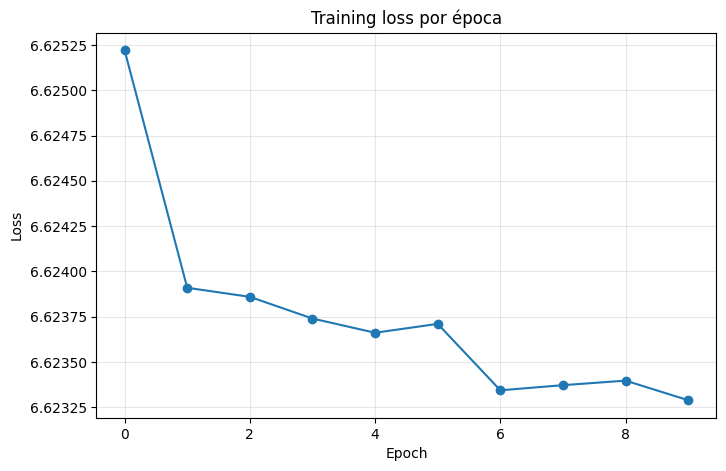

In [7]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

losses = train_decision_transformer(
    model,
    train_loader,
    optimizer,
    DEVICE,
    num_epochs=10
)

plt.figure(figsize=(8,5))
plt.plot(losses, marker="o")
plt.title("Training loss por época")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()


El modelo comienza con un valor de pérdida cercano a 6.625, que es consistente con el valor esperado para una tarea de clasificación sobre 752 clases (equivalente a recomendar una película entre 752 opciones posibles).
Durante el entrenamiento, la pérdida disminuye gradualmente hasta ~6.623.

Si bien la mejora es pequeña, demuestra que el modelo sí está aprendiendo patrones en los datos.

# Ajustes de hiperparametros

### Aumentar epochs de 10 → 30
Un epoch representa una pasada completa por todos los datos de entrenamiento.

Al aumentar de 10 → 30 epochs, el modelo verá 16.000 trayectorias 3 veces más.

In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

losses = train_decision_transformer(
    model=model,
    loader=train_loader,
    optimizer=optimizer,
    device=DEVICE,
    num_epochs=30
)


Epoch 1/30: 100%|██████████| 250/250 [00:11<00:00, 21.44it/s]


✅ Epoch 1: loss promedio = 6.6232


Epoch 2/30: 100%|██████████| 250/250 [00:11<00:00, 21.42it/s]


✅ Epoch 2: loss promedio = 6.6233


Epoch 3/30: 100%|██████████| 250/250 [00:11<00:00, 21.39it/s]


✅ Epoch 3: loss promedio = 6.6232


Epoch 4/30: 100%|██████████| 250/250 [00:11<00:00, 21.11it/s]


✅ Epoch 4: loss promedio = 6.6231


Epoch 5/30: 100%|██████████| 250/250 [00:11<00:00, 21.05it/s]


✅ Epoch 5: loss promedio = 6.6231


Epoch 6/30: 100%|██████████| 250/250 [00:11<00:00, 21.00it/s]


✅ Epoch 6: loss promedio = 6.6231


Epoch 7/30: 100%|██████████| 250/250 [00:11<00:00, 20.91it/s]


✅ Epoch 7: loss promedio = 6.6230


Epoch 8/30: 100%|██████████| 250/250 [00:11<00:00, 20.93it/s]


✅ Epoch 8: loss promedio = 6.6230


Epoch 9/30: 100%|██████████| 250/250 [00:11<00:00, 20.89it/s]


✅ Epoch 9: loss promedio = 6.6230


Epoch 10/30: 100%|██████████| 250/250 [00:12<00:00, 20.69it/s]


✅ Epoch 10: loss promedio = 6.6230


Epoch 11/30: 100%|██████████| 250/250 [00:12<00:00, 20.71it/s]


✅ Epoch 11: loss promedio = 6.6228


Epoch 12/30: 100%|██████████| 250/250 [00:12<00:00, 20.72it/s]


✅ Epoch 12: loss promedio = 6.6229


Epoch 13/30: 100%|██████████| 250/250 [00:12<00:00, 20.63it/s]


✅ Epoch 13: loss promedio = 6.6228


Epoch 14/30: 100%|██████████| 250/250 [00:12<00:00, 20.54it/s]


✅ Epoch 14: loss promedio = 6.6229


Epoch 15/30: 100%|██████████| 250/250 [00:12<00:00, 20.47it/s]


✅ Epoch 15: loss promedio = 6.6228


Epoch 16/30: 100%|██████████| 250/250 [00:12<00:00, 20.57it/s]


✅ Epoch 16: loss promedio = 6.6228


Epoch 17/30: 100%|██████████| 250/250 [00:12<00:00, 20.59it/s]


✅ Epoch 17: loss promedio = 6.6227


Epoch 18/30: 100%|██████████| 250/250 [00:11<00:00, 20.93it/s]


✅ Epoch 18: loss promedio = 6.6228


Epoch 19/30: 100%|██████████| 250/250 [00:12<00:00, 20.73it/s]


✅ Epoch 19: loss promedio = 6.6227


Epoch 20/30: 100%|██████████| 250/250 [00:12<00:00, 20.63it/s]


✅ Epoch 20: loss promedio = 6.6227


Epoch 21/30: 100%|██████████| 250/250 [00:12<00:00, 20.71it/s]


✅ Epoch 21: loss promedio = 6.6227


Epoch 22/30: 100%|██████████| 250/250 [00:12<00:00, 20.65it/s]


✅ Epoch 22: loss promedio = 6.6226


Epoch 23/30: 100%|██████████| 250/250 [00:12<00:00, 20.58it/s]


✅ Epoch 23: loss promedio = 6.6227


Epoch 24/30: 100%|██████████| 250/250 [00:12<00:00, 20.44it/s]


✅ Epoch 24: loss promedio = 6.6227


Epoch 25/30: 100%|██████████| 250/250 [00:11<00:00, 20.86it/s]


✅ Epoch 25: loss promedio = 6.6226


Epoch 26/30: 100%|██████████| 250/250 [00:10<00:00, 23.16it/s]


✅ Epoch 26: loss promedio = 6.6226


Epoch 27/30: 100%|██████████| 250/250 [00:10<00:00, 23.02it/s]


✅ Epoch 27: loss promedio = 6.6226


Epoch 28/30: 100%|██████████| 250/250 [00:10<00:00, 22.98it/s]


✅ Epoch 28: loss promedio = 6.6226


Epoch 29/30: 100%|██████████| 250/250 [00:10<00:00, 22.96it/s]


✅ Epoch 29: loss promedio = 6.6226


Epoch 30/30: 100%|██████████| 250/250 [00:10<00:00, 23.09it/s]

✅ Epoch 30: loss promedio = 6.6226


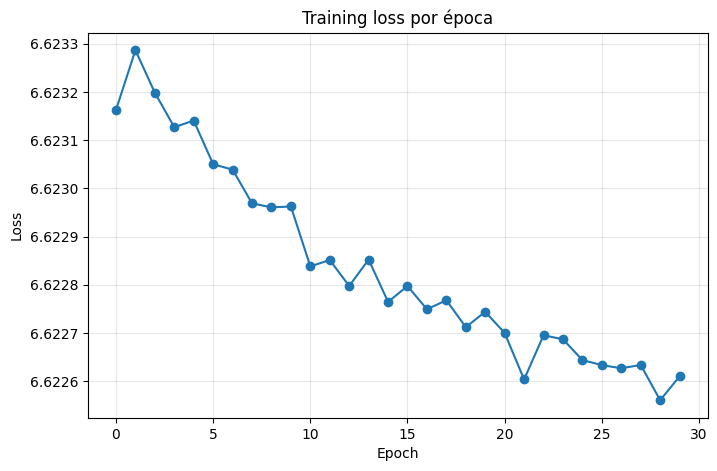

In [9]:
plt.figure(figsize=(8,5))
plt.plot(losses, marker="o")
plt.title("Training loss por época")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()


Al aumentar a 30 épocas, la loss disminuye levemente (~0.0006) y luego se estabiliza, indicando que el modelo aprende pero entra rápido en meseta con esta configuración.

Esto indica que el modelo ya había convergido y que entrenar más no produce mejoras sustanciales

### Aumentar learning rate de 1e-4 a 3e-4
El learning rate (LR) controla qué tan rápido aprende el modelo:

LR muy bajo → aprendizaje lento, loss baja despacito

LR muy alto → el modelo puede volverse inestable 

Vamos a evaluar si aumentar la velocidad de aprendizaje del optimizador AdamW hace converger mejor al modelo.

Epoch 1/10: 100%|██████████| 250/250 [00:12<00:00, 20.10it/s]


✅ Epoch 1: loss promedio = 6.6246


Epoch 2/10: 100%|██████████| 250/250 [00:12<00:00, 20.30it/s]


✅ Epoch 2: loss promedio = 6.6238


Epoch 3/10: 100%|██████████| 250/250 [00:12<00:00, 20.22it/s]


✅ Epoch 3: loss promedio = 6.6234


Epoch 4/10: 100%|██████████| 250/250 [00:12<00:00, 20.07it/s]


✅ Epoch 4: loss promedio = 6.6232


Epoch 5/10: 100%|██████████| 250/250 [00:12<00:00, 20.34it/s]


✅ Epoch 5: loss promedio = 6.6231


Epoch 6/10: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


✅ Epoch 6: loss promedio = 6.6231


Epoch 7/10: 100%|██████████| 250/250 [00:12<00:00, 20.11it/s]


✅ Epoch 7: loss promedio = 6.6229


Epoch 8/10: 100%|██████████| 250/250 [00:12<00:00, 20.01it/s]


✅ Epoch 8: loss promedio = 6.6228


Epoch 9/10: 100%|██████████| 250/250 [00:12<00:00, 19.91it/s]


✅ Epoch 9: loss promedio = 6.6228


Epoch 10/10: 100%|██████████| 250/250 [00:12<00:00, 19.92it/s]


✅ Epoch 10: loss promedio = 6.6227


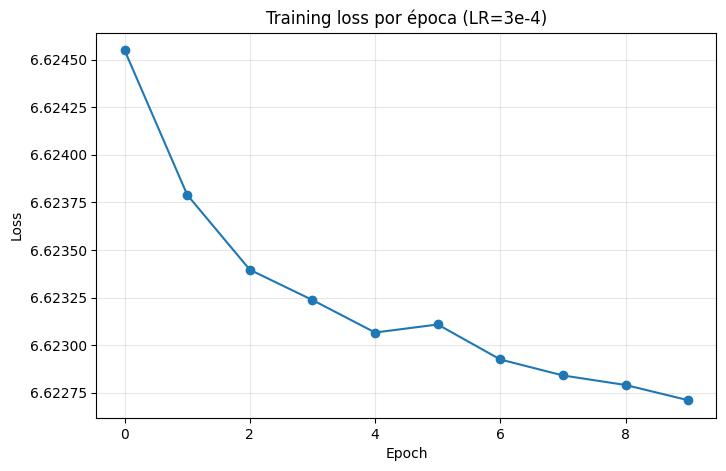

In [10]:
model = DecisionTransformer(
    num_items=NUM_ITEMS,
    num_groups=NUM_GROUPS,
    hidden_dim=128,
    n_layers=3,
    n_heads=4,
    context_length=CONTEXT_LEN
).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

losses_lr = train_decision_transformer(
    model=model,
    loader=train_loader,
    optimizer=optimizer,
    device=DEVICE,
    num_epochs=10
)

plt.figure(figsize=(8,5))
plt.plot(losses_lr, marker="o")
plt.title("Training loss por época (LR=3e-4)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()


Probamos aumentar el learning rate de 1e-4 a 3e-4 manteniendo el resto de los parámetros fijos.
El resultado fue positivo: la pérdida disminuyó más rápido y de forma más clara durante las primeras épocas.

La loss pasó de 6.6246 → 6.6227, mostrando una mejora más marcada que con el LR original.

### Aumentar context_length 20 a 30

Probaremos aumentar el context_length, que es la cantidad de interacciones recientes (películas + ratings) que el modelo usa como entrada para predecir el siguiente ítem.

context_length = 20 → el modelo ve las últimas 20 películas del usuario

context_length = 30 → el modelo ve las últimas 30 películas

La intuición es que, si el modelo ve más historial del usuario, quizás pueda capturar mejor sus preferencias.

La versión original del Dataset no realizaba padding, por lo que las secuencias tenían longitudes distintas según cada usuario. Al aumentar el context_length de 20 a 30, aparecieron usuarios cuya historia no tenía suficientes interacciones, generando error por ello es necesario modificar el dataset

In [ ]:
class RecommendationDataset(Dataset):
    def __init__(self, trajectories, context_length=20, pad_item=0):
        self.trajectories = trajectories
        self.context_length = context_length
        self.pad_item = pad_item  # item de relleno

    def __len__(self):
        return len(self.trajectories)

    def __getitem__(self, idx):
        traj = self.trajectories[idx]

        items = traj["items"]
        rtg = traj["returns_to_go"]
        timesteps = traj["timesteps"]
        group = traj["user_group"]

        L = self.context_length

        # --- elegir ventana ---
        if len(items) >= L:
            start = np.random.randint(0, len(items) - L + 1)
            end = start + L
            items_win = items[start:end]
            rtg_win = rtg[start:end]
            time_win = timesteps[start:end]
        else:
            items_win = items
            rtg_win = rtg
            time_win = timesteps

        seq_len = len(items_win)

        # targets = próximo item
        targets_win = np.empty(seq_len, dtype=np.int64)
        targets_win[:-1] = items_win[1:]
        targets_win[-1] = -1 

        # --- padding ---
        pad_len = L - seq_len
        if pad_len > 0:
            items_win = np.pad(items_win, (0, pad_len), constant_values=self.pad_item)
            targets_win = np.pad(targets_win, (0, pad_len), constant_values=-1)
            rtg_win = np.pad(rtg_win, (0, pad_len), constant_values=0)
            time_win = np.pad(time_win, (0, pad_len), constant_values=0)

        # attention mask: 1 = real, 0 = padding
        attention_mask = np.zeros(L, dtype=np.float32)
        attention_mask[:seq_len] = 1.0

        return {
            "states": torch.tensor(items_win, dtype=torch.long),
            "actions": torch.tensor(items_win, dtype=torch.long),
            "rtg": torch.tensor(rtg_win.reshape(-1, 1), dtype=torch.float32),
            "timesteps": torch.tensor(time_win, dtype=torch.long),
            "groups": torch.tensor(group, dtype=torch.long),
            "targets": torch.tensor(targets_win, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.float32)
        }


In [21]:
class DecisionTransformer(nn.Module):
    def __init__(
        self,
        num_items=752,
        num_groups=8,
        hidden_dim=128,
        n_layers=3,
        n_heads=4,
        context_length=20,
        max_timestep=200,
        dropout=0.1
    ):
        super().__init__()

        self.num_items = num_items
        self.hidden_dim = hidden_dim
        self.context_length = context_length

        # Embeddings
        self.item_embedding = nn.Embedding(num_items, hidden_dim)
        self.group_embedding = nn.Embedding(num_groups, hidden_dim)
        self.rtg_embedding = nn.Linear(1, hidden_dim)
        self.timestep_embedding = nn.Embedding(max_timestep, hidden_dim)

        # Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation="gelu",
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Output head
        self.predict_item = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_items)
        )

        self.ln = nn.LayerNorm(hidden_dim)

    def forward(self, states, actions, rtg, timesteps, groups, attention_mask=None):
        B, L = states.shape

        state_emb = self.item_embedding(states)
        rtg_emb = self.rtg_embedding(rtg)
        time_emb = self.timestep_embedding(timesteps)

        group_emb = self.group_embedding(groups).unsqueeze(1)
        group_emb = group_emb.expand(-1, L, -1)

        h = state_emb + rtg_emb + time_emb + group_emb
        h = self.ln(h)

        # causal mask (autoregresivo)
        causal_mask = torch.triu(torch.ones(L, L) * float("-inf"), diagonal=1).to(h.device)

        # padding mask
        if attention_mask is not None:
            key_padding_mask = (attention_mask == 0)
        else:
            key_padding_mask = None

        h = self.transformer(
            h,
            mask=causal_mask,
            src_key_padding_mask=key_padding_mask
        )

        return self.predict_item(h)


In [22]:
CONTEXT_LEN = 30

train_dataset = RecommendationDataset(trajectories, context_length=CONTEXT_LEN)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

batch = next(iter(train_loader))
{k: v.shape for k, v in batch.items()}


{'states': torch.Size([64, 30]),
 'actions': torch.Size([64, 30]),
 'rtg': torch.Size([64, 30, 1]),
 'timesteps': torch.Size([64, 30]),
 'groups': torch.Size([64]),
 'targets': torch.Size([64, 30]),
 'attention_mask': torch.Size([64, 30])}

In [24]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = DecisionTransformer(
    num_items=752,
    num_groups=8,
    hidden_dim=128,
    n_layers=3,
    n_heads=4,
    context_length=CONTEXT_LEN
).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

model


DecisionTransformer(
  (item_embedding): Embedding(752, 128)
  (group_embedding): Embedding(8, 128)
  (rtg_embedding): Linear(in_features=1, out_features=128, bias=True)
  (timestep_embedding): Embedding(200, 128)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (predict_item): Sequential(
    (0): Linear(in_features=128, out_features=1

In [25]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_decision_transformer(model, loader, optimizer, device, num_epochs=10):
    model.train()
    losses = []

    for epoch in range(num_epochs):
        total_loss = 0

        for batch in tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}"):

            states = batch["states"].to(device)
            actions = batch["actions"].to(device)
            rtg = batch["rtg"].to(device)
            timesteps = batch["timesteps"].to(device)
            groups = batch["groups"].to(device)
            targets = batch["targets"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            logits = model(states, actions, rtg, timesteps, groups, attention_mask)

            loss = F.cross_entropy(
                logits.reshape(-1, model.num_items),
                targets.reshape(-1),
                ignore_index=-1
            )

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()

        avg = total_loss / len(loader)
        losses.append(avg)
        print(f"✅ Epoch {epoch+1}: loss promedio = {avg:.4f}")

    return losses


Epoch 1/10:   0%|          | 0/250 [00:00<?, ?it/s]/Users/mariamicaelazamorano/.pyenv/versions/3.11.14/lib/python3.11/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
Epoch 1/10: 100%|██████████| 250/250 [00:14<00:00, 17.69it/s]


✅ Epoch 1: loss promedio = 6.6245


Epoch 2/10: 100%|██████████| 250/250 [00:13<00:00, 17.89it/s]


✅ Epoch 2: loss promedio = 6.6236


Epoch 3/10: 100%|██████████| 250/250 [00:14<00:00, 17.47it/s]


✅ Epoch 3: loss promedio = 6.6233


Epoch 4/10: 100%|██████████| 250/250 [00:14<00:00, 17.85it/s]


✅ Epoch 4: loss promedio = 6.6232


Epoch 5/10: 100%|██████████| 250/250 [00:13<00:00, 18.12it/s]


✅ Epoch 5: loss promedio = 6.6230


Epoch 6/10: 100%|██████████| 250/250 [00:13<00:00, 18.14it/s]


✅ Epoch 6: loss promedio = 6.6229


Epoch 7/10: 100%|██████████| 250/250 [00:13<00:00, 18.20it/s]


✅ Epoch 7: loss promedio = 6.6229


Epoch 8/10: 100%|██████████| 250/250 [00:13<00:00, 18.14it/s]


✅ Epoch 8: loss promedio = 6.6227


Epoch 9/10: 100%|██████████| 250/250 [00:13<00:00, 18.02it/s]


✅ Epoch 9: loss promedio = 6.6227


Epoch 10/10: 100%|██████████| 250/250 [00:13<00:00, 18.05it/s]

✅ Epoch 10: loss promedio = 6.6227


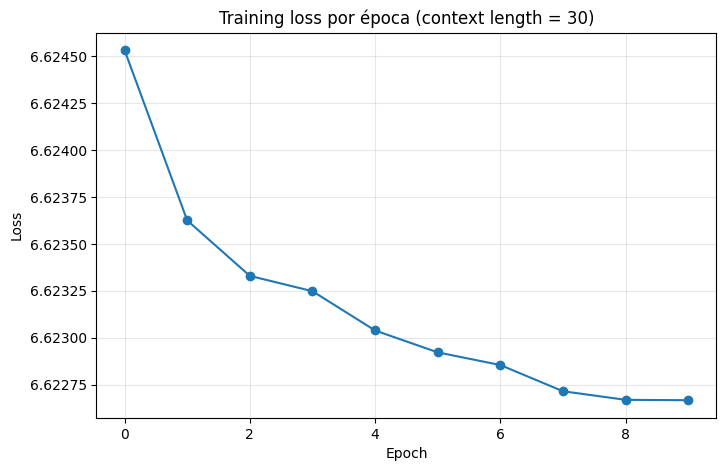

In [26]:
losses_ctx = train_decision_transformer(
    model=model,
    loader=train_loader,
    optimizer=optimizer,
    device=DEVICE,
    num_epochs=10
)

plt.figure(figsize=(8,5))
plt.plot(losses_ctx, marker="o")
plt.title("Training loss por época (context length = 30)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()


Aumentar context length de 20 a 30 no produjo mejoras claras en la loss final en 10 épocas. La curva mantiene estabilidad y converge a valores similares. Esto sugiere que, con esta capacidad de modelo, el beneficio de ver más historial es limitado.

### Más capacidad → hidden_dim 128 → 256

El parámetro hidden_dim controla el tamaño de los vectores internos que maneja el Transformer:

* El tamaño de las embeddings

* El tamaño de las representaciones internas en cada capa

* La cantidad de información que cada token puede codificar

In [27]:
model = DecisionTransformer(
    num_items=NUM_ITEMS,
    num_groups=NUM_GROUPS,
    hidden_dim=256,      
    n_layers=3,
    n_heads=4,
    context_length=CONTEXT_LEN
).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
model


DecisionTransformer(
  (item_embedding): Embedding(752, 256)
  (group_embedding): Embedding(8, 256)
  (rtg_embedding): Linear(in_features=1, out_features=256, bias=True)
  (timestep_embedding): Embedding(200, 256)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (predict_item): Sequential(
    (0): Linear(in_features=256, out_features

Epoch 1/10: 100%|██████████| 250/250 [00:23<00:00, 10.82it/s]


✅ Epoch 1: loss promedio = 6.6241


Epoch 2/10: 100%|██████████| 250/250 [00:23<00:00, 10.76it/s]


✅ Epoch 2: loss promedio = 6.6231


Epoch 3/10: 100%|██████████| 250/250 [00:23<00:00, 10.60it/s]


✅ Epoch 3: loss promedio = 6.6230


Epoch 4/10: 100%|██████████| 250/250 [00:23<00:00, 10.61it/s]


✅ Epoch 4: loss promedio = 6.6229


Epoch 5/10: 100%|██████████| 250/250 [00:23<00:00, 10.50it/s]


✅ Epoch 5: loss promedio = 6.6228


Epoch 6/10: 100%|██████████| 250/250 [00:23<00:00, 10.53it/s]


✅ Epoch 6: loss promedio = 6.6227


Epoch 7/10: 100%|██████████| 250/250 [00:24<00:00, 10.39it/s]


✅ Epoch 7: loss promedio = 6.6227


Epoch 8/10: 100%|██████████| 250/250 [00:24<00:00, 10.22it/s]


✅ Epoch 8: loss promedio = 6.6227


Epoch 9/10: 100%|██████████| 250/250 [00:24<00:00, 10.31it/s]


✅ Epoch 9: loss promedio = 6.6226


Epoch 10/10: 100%|██████████| 250/250 [00:24<00:00, 10.31it/s]

✅ Epoch 10: loss promedio = 6.6226


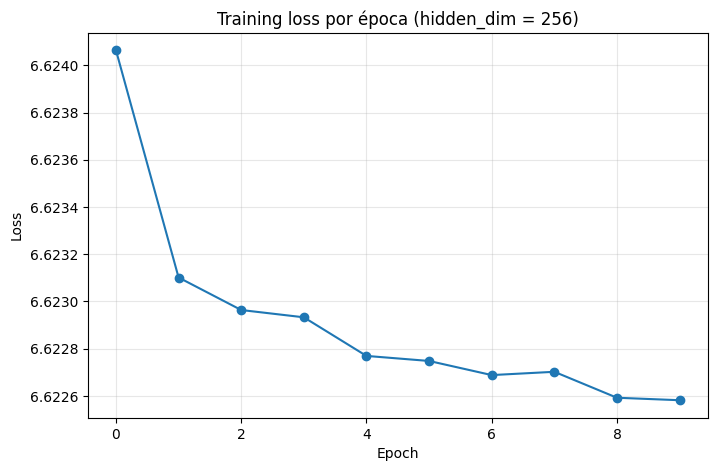

In [28]:
losses_hd256 = train_decision_transformer(
    model=model,
    loader=train_loader,
    optimizer=optimizer,
    device=DEVICE,
    num_epochs=10
)

plt.figure(figsize=(8,5))
plt.plot(losses_hd256, marker="o")
plt.title("Training loss por época (hidden_dim = 256)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()


Aumentamos el tamaño del espacio latente del modelo de 128 a 256 dimensiones para evaluar si una mayor capacidad expresiva permite capturar patrones más complejos del comportamiento de los usuarios. Sin embargo, el loss solo mejora de 6.6241 a 6.6226, lo cual es marginal y comparable con los otros experimentos.
Además, el tiempo de entrenamiento por época se duplicó.
Concluimos que hidden_dim=128 es suficiente para este dataset y este entorno de hardware (CPU)

Los hiperparámetros aparentemente no son el problema.

En base a las recomendaciones vamos a probar si el problema está en la causal mask del transformer.

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DecisionTransformer(nn.Module):
    def __init__(
        self,
        num_items=752,
        num_groups=8,
        hidden_dim=128,
        n_layers=3,
        n_heads=4,
        context_length=20,
        max_timestep=200,
        dropout=0.1
    ):
        super().__init__()

        self.num_items = num_items
        self.hidden_dim = hidden_dim
        self.context_length = context_length

        # === EMBEDDINGS ===
        self.item_embedding = nn.Embedding(num_items, hidden_dim)
        self.group_embedding = nn.Embedding(num_groups, hidden_dim)
        self.rtg_embedding = nn.Linear(1, hidden_dim)
        self.timestep_embedding = nn.Embedding(max_timestep, hidden_dim)

        # === TRANSFORMER ===
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=n_layers,
            enable_nested_tensor=False
        )

        # === OUTPUT HEAD ===
        self.predict_item = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_items)
        )

        self.ln = nn.LayerNorm(hidden_dim)

    def forward(self, states, actions, returns_to_go, timesteps, user_groups, attention_mask=None):
        B, L = states.shape

        # ===== EMBED =====
        state_emb = self.item_embedding(states)
        rtg_emb = self.rtg_embedding(returns_to_go)
        time_emb = self.timestep_embedding(timesteps)

        group_emb = self.group_embedding(user_groups).unsqueeze(1)
        group_emb = group_emb.expand(-1, L, -1)

        h = state_emb + rtg_emb + time_emb + group_emb
        h = self.ln(h)

        # ===== CAUSAL MASK OBLIGATORIA PARA PYTORCH 2.9 =====
        # forma: (L, L)
        causal_mask = nn.Transformer.generate_square_subsequent_mask(L).to(h.device)

        # ===== PADDING MASK OPCIONAL =====
        if attention_mask is not None:
            src_key_padding_mask = (attention_mask == 0)   # True = ignorar
        else:
            src_key_padding_mask = None

        # ===== TRANSFORMER =====
        h = self.transformer(
            h,
            mask=causal_mask,
            src_key_padding_mask=src_key_padding_mask
        )

        logits = self.predict_item(h)
        return logits


Reconstruimos el modelo

In [40]:
model = DecisionTransformer(
    num_items=NUM_ITEMS,
    num_groups=NUM_GROUPS,
    hidden_dim=128,
    n_layers=3,
    n_heads=4,
    context_length=CONTEXT_LEN
).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

model


DecisionTransformer(
  (item_embedding): Embedding(752, 128)
  (group_embedding): Embedding(8, 128)
  (rtg_embedding): Linear(in_features=1, out_features=128, bias=True)
  (timestep_embedding): Embedding(200, 128)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (predict_item): Sequential(
    (0): Linear(in_features=128, out_features=1

Entrenamos

Epoch 1/10: 100%|██████████| 250/250 [00:13<00:00, 18.31it/s]


✅ Epoch 1: loss promedio = 6.6251


Epoch 2/10: 100%|██████████| 250/250 [00:13<00:00, 18.23it/s]


✅ Epoch 2: loss promedio = 6.6237


Epoch 3/10: 100%|██████████| 250/250 [00:13<00:00, 18.12it/s]


✅ Epoch 3: loss promedio = 6.6233


Epoch 4/10: 100%|██████████| 250/250 [00:13<00:00, 18.64it/s]


✅ Epoch 4: loss promedio = 6.6233


Epoch 5/10: 100%|██████████| 250/250 [00:13<00:00, 18.68it/s]


✅ Epoch 5: loss promedio = 6.6230


Epoch 6/10: 100%|██████████| 250/250 [00:13<00:00, 18.47it/s]


✅ Epoch 6: loss promedio = 6.6229


Epoch 7/10: 100%|██████████| 250/250 [00:13<00:00, 18.14it/s]


✅ Epoch 7: loss promedio = 6.6228


Epoch 8/10: 100%|██████████| 250/250 [00:14<00:00, 17.48it/s]


✅ Epoch 8: loss promedio = 6.6228


Epoch 9/10: 100%|██████████| 250/250 [00:13<00:00, 18.23it/s]


✅ Epoch 9: loss promedio = 6.6227


Epoch 10/10: 100%|██████████| 250/250 [00:13<00:00, 18.04it/s]

✅ Epoch 10: loss promedio = 6.6226


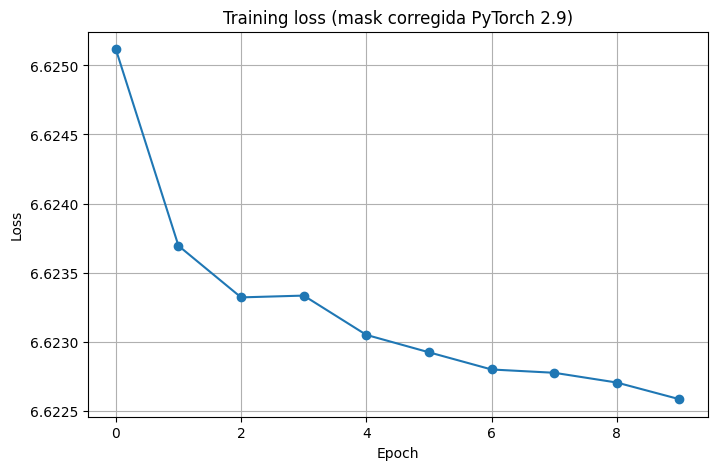

Loss final: 6.622582437515259


In [41]:
losses_fixedmask = train_decision_transformer(
    model=model,
    loader=train_loader,
    optimizer=optimizer,
    device=DEVICE,
    num_epochs=10
)

plt.figure(figsize=(8,5))
plt.plot(losses_fixedmask, marker="o")
plt.title("Training loss (mask corregida PyTorch 2.9)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

print("Loss final:", losses_fixedmask[-1])


Al corregir la causal mask para PyTorch 2.9, el entrenamiento se ejecuta ok. El loss disminuye de 6.6251 a 6.6226 en 10 épocas, mostrando una mejora muy leve. 

### Interpretación del entrenamiento:
El loss es Cross-Entropy sobre 752 clases posibles (películas).
En este escenario, un modelo casi aleatorio tiene un loss esperado cercano a log(752) ≈ 6.62, que es justamente el valor que observamos.
Esto sugiere que el modelo aún no logra mejorar de forma clara sobre el baseline aleatorio con estos hiperparámetros y entrenamiento corto, pero sirve como implementación funcional completa del Decision Transformer.

### Guardado del modelo
Para preservar los pesos del Decision Transformer entrenado, guardamos el state_dict en la carpeta results/checkpoints. Esto permite reutilizar el modelo en los notebooks siguientes sin necesidad de volver a entrenarlo. Solo guardamos los pesos (no el optimizador ni el grafo), lo cual es suficiente para la etapa de evaluación.

In [43]:
import datetime, os, torch

os.makedirs("../results/checkpoints", exist_ok=True)

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
ckpt_path = f"../results/checkpoints/dt_netflix.pth"

torch.save(model.state_dict(), ckpt_path)
print("✅ checkpoint guardado en:", ckpt_path)



✅ checkpoint guardado en: ../results/checkpoints/dt_netflix.pth
